/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-2-72eb02750a9b>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_rules['antecedents_str'] = refined_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
<ipython-input-2-72eb02750a9b>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation


Refined Association Rules:
   antecedents_str consequents_str  confidence  lift association_type  \
0           coffer           Bread         1.0  1.50         Positive   
3         Biscuits           Bread         1.0  1.50         Positive   
4         Biscuits             tea         1.0  2.25         Positive   
6              tea           Bread         1.0  1.50         Positive   
7  Bread, Biscuits             tea         1.0  2.25         Positive   
8    Biscuits, tea           Bread         1.0  1.50         Positive   
9         Biscuits      Bread, tea         1.0  2.25         Positive   

  description  
0         NaN  
3         NaN  
4         NaN  
6         NaN  
7         NaN  
8         NaN  
9         NaN  

IFP-Tree Structure:
NULL: 0
  Bread: 6
    tea: 4
      Biscuits: 1
        tea: 1
          Biscuits: 1
            Biscuits: 1
    Butter: 1
      tea: 1
        Butter: 1
          Butter: 1
     coffer: 4
       coffer: 1
    Biscuits: 1
      tea: 1
   

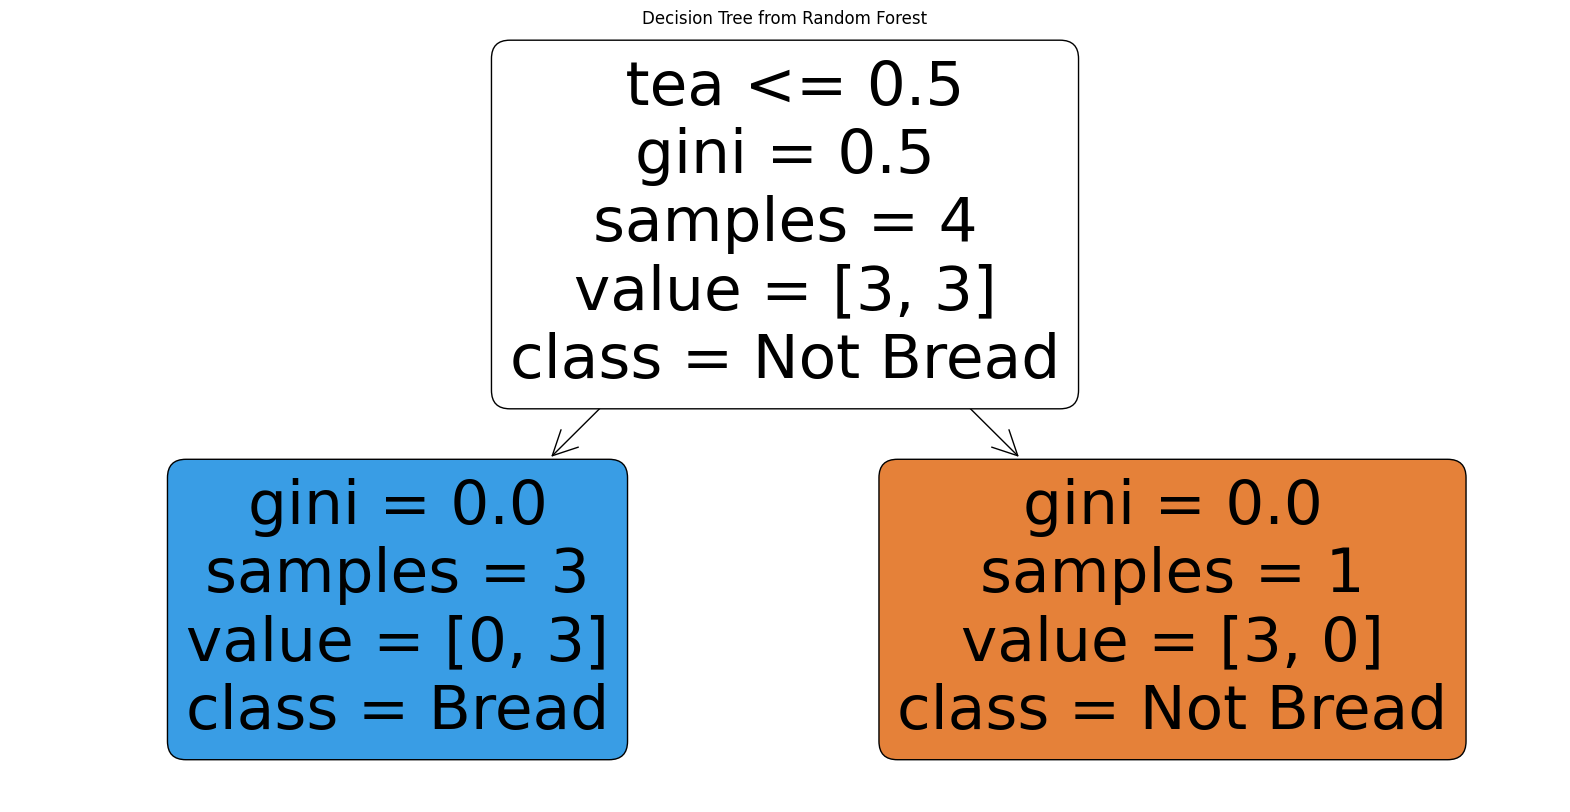


Sequential Patterns:
     support                         itemsets
0   0.583333                        ( coffer)
1   0.583333                           ( tea)
2   0.416667                       (Biscuits)
3   0.916667                          (Bread)
4   0.416667                         (Butter)
5   0.583333                         (coffer)
6   0.722222                            (tea)
7   0.250000                  ( coffer,  tea)
8   0.277778              ( coffer, Biscuits)
9   0.583333                 ( coffer, Bread)
10  0.250000                ( coffer, coffer)
11  0.388889                   ( coffer, tea)
12  0.500000                    ( tea, Bread)
13  0.277778                   ( tea, Butter)
14  0.444444                   ( tea, coffer)
15  0.333333                      ( tea, tea)
16  0.416667                (Bread, Biscuits)
17  0.416667                  (Biscuits, tea)
18  0.361111                  (Bread, Butter)
19  0.500000                  (Bread, coffer)
20  0.722222

In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import itertools

class TreeNode:
    def __init__(self, item, count=1):
        self.item = item
        self.count = count
        self.children = {}

# Read the dataset
file_path = 'dataset_min.csv'
data = pd.read_csv(file_path)

# Data Pre-processing
data['Items'] = data['Items'].fillna('')
transactions = data['Items'].apply(lambda x: x.split(', ') if x else []).tolist()

# Transaction encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Generate frequent itemsets and association rules
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Create support data for negative rule generation
support_data = {frozenset(itemset): support for itemset, support in zip(frequent_itemsets['itemsets'], frequent_itemsets['support'])}

# Function to create negative rules
def create_negative_rules(rules, support_data):
    negative_rules = []
    for index, row in rules.iterrows():
        antecedent, consequent = row['antecedents'], row['consequents']

        support_antecedent = support_data[frozenset(antecedent)]
        support_consequent = support_data[frozenset(consequent)]
        support_antecedent_consequent = support_data[frozenset(antecedent | consequent)]

        if support_antecedent < 1:
            confidence_negA_B = (support_consequent - support_antecedent_consequent) / (1 - support_antecedent)
            negative_rules.append({
                'antecedents': frozenset(),
                'consequents': antecedent,
                'confidence': confidence_negA_B,
                'neg_association': 1,
                'description': f"NAR-{len(negative_rules) + 1}: ~{antecedent} => {consequent}"
            })

        if support_antecedent > 0:
            confidence_A_negB = (support_antecedent - support_antecedent_consequent) / support_antecedent
            negative_rules.append({
                'antecedents': antecedent,
                'consequents': frozenset(),
                'confidence': confidence_A_negB,
                'neg_association': 1,
                'description': f"NAR-{len(negative_rules) + 1}: {antecedent} => ~{consequent}"
            })

        if support_antecedent < 1 and support_consequent < 1:
            confidence_negA_negB = (1 - support_antecedent - support_consequent + support_antecedent_consequent) / (1 - support_antecedent)
            negative_rules.append({
                'antecedents': frozenset(),
                'consequents': frozenset(),
                'confidence': confidence_negA_negB,
                'neg_association': 1,
                'description': f"NAR-{len(negative_rules) + 1}: ~{antecedent} => ~{consequent}"
            })

    return pd.DataFrame(negative_rules)

negative_rules_df = create_negative_rules(rules, support_data)

# Identifying Association Types
rules['association_type'] = 'Positive'
negative_rules_df['association_type'] = 'Negative'

combined_rules = pd.concat([rules, negative_rules_df], ignore_index=True)

# Refinement
def refine_rules(rules, min_confidence, min_lift):
    return rules[(rules['confidence'] >= min_confidence) & (rules['lift'] >= min_lift)]

refined_rules = refine_rules(combined_rules, min_confidence=0.7, min_lift=1.2)

# Prepare results table
refined_rules['antecedents_str'] = refined_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
refined_rules['consequents_str'] = refined_rules['consequents'].apply(lambda x: ', '.join(list(x)))

results_table = refined_rules[['antecedents_str', 'consequents_str', 'confidence', 'lift', 'association_type', 'description']]

print("\nRefined Association Rules:")
print(results_table)

# Build IFP-Tree
def build_ifp_tree(transactions, item_support):
    root = TreeNode('NULL', 0)
    sparse_table = defaultdict(int)
    for transaction in transactions:
        sorted_transaction = sorted(transaction, key=lambda x: item_support[x], reverse=True)
        current_node = root
        for i, item in enumerate(sorted_transaction):
            A = item
            B = sorted_transaction[i+1:]
            if A in current_node.children:
                current_node.children[A].count += 1
                current_node = current_node.children[A]
            else:
                new_node = TreeNode(A, 1)
                current_node.children[A] = new_node
                current_node = new_node
            for item_B in B:
                if item_B in current_node.children:
                    current_node.children[item_B].count += 1
                else:
                    new_node_B = TreeNode(item_B, 1)
                    current_node.children[item_B] = new_node_B
                    current_node = new_node_B
                    sparse_table[item_B] += 1
    total_occurrences = defaultdict(int)
    for transaction in transactions:
        unique_items = set(transaction)
        for item in unique_items:
            total_occurrences[item] += 1
    return root, total_occurrences, sparse_table

item_support = {item: support for item, support in zip(te.columns_, df.sum()/len(df))}

ifp_tree, item_occurrences, sparse_count = build_ifp_tree(transactions, item_support)

print("\nIFP-Tree Structure:")
def print_tree(node, indent=""):
    print(indent + f"{node.item}: {node.count}")
    for child in node.children.values():
        print_tree(child, indent + "  ")

print_tree(ifp_tree)

# Train via RF Model
X = df.drop(columns=['Bread'])  # Use all items except 'Bread' as features
y = df['Bread']  # Predict 'Bread'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Visualize one tree from the random forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X.columns, class_names=['Not Bread', 'Bread'], filled=True, rounded=True)
plt.title("Decision Tree from Random Forest")
plt.show()




# Extended Pattern Techniques (EPT)

# 1. Sequential Pattern Mining
def generate_sequences(transactions):
    sequences = []
    for i in range(len(transactions)):
        for j in range(i+1, len(transactions)):
            seq = transactions[i] + transactions[j]
            sequences.append(seq)
    return sequences

def sequential_pattern_mining(sequences, min_support=0.2):
    te = TransactionEncoder()
    te_ary = te.fit(sequences).transform(sequences)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    return frequent_itemsets

sequences = generate_sequences(transactions)
sequential_patterns = sequential_pattern_mining(sequences)

print("\nSequential Patterns:")
print(sequential_patterns)

# 2. Periodic Pattern Mining
def find_periodic_patterns(transactions, max_period=3, min_support=0.2):
    item_occurrences = defaultdict(list)
    for i, transaction in enumerate(transactions):
        for item in transaction:
            item_occurrences[item].append(i)

    periodic_patterns = []
    for item, occurrences in item_occurrences.items():
        periods = [occurrences[i+1] - occurrences[i] for i in range(len(occurrences)-1)]
        if periods and max(periods) <= max_period:
            support = len(occurrences) / len(transactions)
            if support >= min_support:
                periodic_patterns.append((item, support, max(periods)))

    return periodic_patterns

periodic_patterns = find_periodic_patterns(transactions)

print("\nPeriodic Patterns:")
for pattern in periodic_patterns:
    print(f"Item: {pattern[0]}, Support: {pattern[1]:.2f}, Max Period: {pattern[2]}")

# 3. Approximate Pattern Matching
def approximate_pattern_matching(transactions, pattern, max_edit_distance=1):
    matches = []
    for i, transaction in enumerate(transactions):
        for j in range(len(transaction) - len(pattern) + 1):
            sub_transaction = transaction[j:j+len(pattern)]
            edit_distance = sum(a != b for a, b in zip(sub_transaction, pattern))
            if edit_distance <= max_edit_distance:
                matches.append((i, j, edit_distance))
    return matches

pattern_to_match = ['tea', 'Biscuits']
approximate_matches = approximate_pattern_matching(transactions, pattern_to_match)

print("\nApproximate Pattern Matches:")
for match in approximate_matches:
    print(f"Transaction {match[0]}, Position {match[1]}, Edit Distance {match[2]}")

# 4. Pattern Summarization
def summarize_patterns(frequent_itemsets, top_n=5):
    sorted_patterns = frequent_itemsets.sort_values('support', ascending=False)
    return sorted_patterns.head(top_n)

pattern_summary = summarize_patterns(sequential_patterns)

print("\nPattern Summary (Top 5):")
print(pattern_summary)

# 5. Multi-dimensional Pattern Mining
def multi_dimensional_pattern_mining(transactions, dimensions=['Items', 'Length']):
    multi_dim_patterns = []
    for transaction in transactions:
        length = len(transaction)
        for item in transaction:
            pattern = {
                'Items': item,
                'Length': 'Short' if length <= 2 else 'Medium' if length <= 4 else 'Long'
            }
            multi_dim_patterns.append(pattern)

    return pd.DataFrame(multi_dim_patterns)

multi_dim_patterns = multi_dimensional_pattern_mining(transactions)

print("\nMulti-dimensional Patterns:")

print(multi_dim_patterns.value_counts().head())

